# DARP me baby one more time!

In [1]:
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn

In [2]:
from cpp_algorithms.testers import imshow, imshow_scatter
from cpp_algorithms.testers import get_all_area_maps, get_random_coords
from cpp_algorithms.fuel_path.dist_matrix import dist_fill

In [3]:
"""
Initialization
"""
PATH = "./test_maps/"
OBS = -1 # constant for obstacle area
COV =  0 # constant for coverage area

def get_test_init(number_of_drones, idx=0):
    area_map = get_all_area_maps(PATH)[idx]
    n = get_random_coords(area_map, number_of_drones)
    return area_map, n

In [4]:
"""
Helpers
"""
def rmse(a,b):
    """
    Root Mean Square Error
    """
    return ((a - b)**2).mean()**0.5

def get_obstacle_coords(area_map, obstacle=OBS):
    """
    Returns coords of obstacles.
    """
    return np.stack(list(np.where(area_map == obstacle))).T

def has_obstacles(area_map, obstacle=OBS):
    """
    True if the area map has obstacles
    """
    return (area_map == obstacle).sum() > 0

def get_evaluation_matrices(start_points, area_map):
    """
    Returns evaluation matrices for all the drones.
    Which are distance maps from their start_points
    """
    return np.stack([dist_fill(area_map,[sp]) for sp in start_points])

def get_assignment_matrix(E, obstacle=OBS):
    """
    Assigns coord depending on evaluation matrices 
    and returns the matrix.
    """
    mask = (E[0] == obstacle)
    A = E.argmin(axis=0)
    A[mask] = -1
    return A

def get_assigned_count(A, arr=True, obstacle=OBS):
    """
    A : assignment matrix
    return count dict
    """
    c = {}
    uc = np.unique(A, return_counts=True)
    if not arr:
        for drone,count in zip(*uc):
            if drone==obstacle:
                continue
            else:
                c[drone] = count
        return c
    else:
        return uc[1][uc[0] != OBS]

def get_no_obs_count(area_map, obstacle=OBS):
    """
    Return count of points that are not obstacles
    """
    return (area_map != obstacle).sum()

def get_coverage_ratio(drone_speed, drone_coverage):
    """
    Normalized values of the drone coverage per unit time
    """
    coverage_per_time = (drone_coverage**0.5)*drone_speed
    return coverage_per_time/coverage_per_time.sum()

def get_c(area_map):
    """
    area_map : for size calculation
    """
    learning_rate = np.log10(area_map.size) # learning_rate
    return 10**(-np.ceil(learning_rate))    # tunable parameter c

def get_fair_share(i, assigned_count, nobs_count, coverage_ratio):
    """
    assigned_count : number of cells assigned to each drone
    nobs_count : total number of cells that can be covered
    coverage_ratio : ratio of cells to be assigned to each drone
    """
    try:
        return assigned_count[i] - np.round(coverage_ratio * nobs_count)[i]
    except IndexError as error:
        raise IndexError("the vicissitudes of cyclic coordinate descent"\
                        +"\n"+ "count of assigned areas has dropped below `n`"+"\n"+repr(error))

In [5]:
"""
Functions to calculate the contiguity correction matrix.
"""
def get_area_indices(area, value, inv=False, obstacle=OBS):
    """
    returns indices that have value and not obstacle
    if inv returns indices that don't have value and obstacle
    """
    try:
        value = int(value)
        if inv:
            return np.concatenate([np.where((area != value)&(area!=obstacle))]).T
        return np.concatenate([np.where((area == value)&(area!=obstacle))]).T
    except:
        mask = area == value[0]
        if inv:
            mask = area != value[0]
        for v in value[1:]:
            if inv:
                mask &= area != v
            else:
                mask |= area == v
        mask &= area != obstacle
        return np.concatenate([np.where(mask)]).T

def get_region_dist_map(index_matrix, coords):
    """
    Broadcasts coords along index_matrix and returns the min l1
    """
    b_val = index_matrix.shape[0]
    coords = np.broadcast_to(coords, (b_val, *coords.shape))
    assert coords.shape[0] == index_matrix.shape[0] and \
        coords.shape[2] == index_matrix.shape[2], \
        "something went wrong in broadcasting"
    
    # To change the distance function change this line.
    return np.abs(index_matrix - coords).sum(axis=2).min(axis=1)

def get_ci(cont_map, r, q):
    """
    cont_map : continuity map that assigns unique labels to every isolated !obstacle
    r : value of region with the start point
    c : value(s) of region without the start point
    """
    index_matrix = np.indices(cont_map.shape).transpose(1,2,0).reshape(-1, 2)[:,None,:]
    r_indices = get_area_indices(cont_map, r, obstacle=0)
    q_indices = get_area_indices(cont_map, q, obstacle=0)

    min_dist_r = get_region_dist_map(index_matrix, r_indices).reshape(cont_map.shape)
    min_dist_q = get_region_dist_map(index_matrix, q_indices).reshape(cont_map.shape)
    return min_dist_r - min_dist_q

In [6]:
"""
Functions that deal with continuity.
"""
def coord_in_list(coord, list_):
    """
    Checks if coord is present in the list.
    """
    return (np.abs(np.array(coord) - list_).sum(axis=1) ==0).sum() == 1

def continuity_check(A, n, i):
    """
    True if all areas are continuous.
    A : assignment map
    n : number of drones
    """
    cont_map, cont_count = measure.label(A, return_num=True, background=-1)
    xy = get_area_indices(A,i)
    x,y = xy.T
    values_at_xy = cont_map[x,y]
    not_is_cont = len(np.unique(values_at_xy)) > 1
    if not_is_cont:
        return False, xy, values_at_xy, cont_map
    else:
        return True, None, None, None

def continuity_fix(A, E, i, n, mi, start_point, mask, xy, values_at_xy, cont_map):
    """
    Fix continuity when there is none.
    """
    r = None
    q = None
    uniq = np.unique(values_at_xy)
    for v in uniq:
        if coord_in_list(start_point,xy[values_at_xy == v]):
            r = v
            break
    q = uniq[uniq!=r]
    C_i = get_ci(cont_map, r, q)
    C_i[mask] = 1
    E[i] = C_i*mi*E[i]
    
def continuity_check_fix(A, E, i, n, mi, mask, start_point):
    """
    Calculate C_i and fix if `i`th drone's areas are not contiguous.
    """
    is_contig, xy, values_at_xy, cont_map = continuity_check(A, n, i)
    if is_contig:
        return
    else:
        continuity_fix(A, E, i, n, mi, start_point, mask, xy, values_at_xy, cont_map)

In [13]:
"""
loop functions
"""
def apply_mask_E(mask, E, obstacle=OBS):
    E[:, mask] = obstacle
    
def mi_step(start_points, E, m, c, nobs_count, coverage_ratio, obstacle=OBS):
    """
    E : evaluation matrices for all drones
    m : array of m_i values 
    c : tunable parameter
    nobs_count : total area that can be covered
    coverage_ratio : coverage ratio for all drones
    """
    n = E.shape[0]
    mask = E[0] == obstacle
    A = get_assignment_matrix(E) # E changes ∴ A changes
    for i in range(len(m)):
        assigned_count = get_assigned_count(A, arr=True) # Counts of cells assigned to each drone
        fs_i = get_fair_share(i, assigned_count, nobs_count, coverage_ratio) # Difference between optimal and assigned
        m[i] = 1 + c * fs_i # alter the m param
        E[i] = E[i] * m[i]  # update evaluation matrix
        apply_mask_E(mask, E)
        A = get_assignment_matrix(E) # E changes ∴ A changes
        start_point = start_points[i]
        A[start_point] = i # Cause sometimes you lose your start
        continuity_check_fix(A, E, i, n, m[i], mask, start_point)
    return A

def iterate(epochs, start_points, E, c, nobs_count, coverage_ratio, obstacle=OBS, print_stuff=False):
    """
    epochs : number of iterations to iterate the loop in the iterate function for.
    E : initial evaluation matrix for all the drones
    c : tunable paramter `c`
    nobs_count : number of cells that can be covered
    coverage_ratio : ratio of coverage
    """
    n = E.shape[0]
    m = np.ones(n, dtype=np.float32)
    optimal_count = np.round(coverage_ratio * nobs_count)
    best_A = get_assignment_matrix(E)
    min_loss = float('inf')
    for i in range(epochs):
        try:
            A = mi_step(start_points, E, m, c, nobs_count, coverage_ratio)
            assigned_count = get_assigned_count(A)
            loss = rmse(assigned_count, optimal_count)
            if print_stuff:
                print(f"ASGN : {assigned_count}\nRMSE : {loss:0.2f}")
        except IndexError:
            warn("assigned areas may have gone below number of drones, run for fewer epochs")
            return best_A
        if loss < min_loss:
            min_loss = loss
            best_A = A
    return best_A

In [14]:
# Initilize values
n = 3
area_map, start_points = get_test_init(n,10) # get test values
# drone_speed = np.array([1,0.5,1])          # distance^2/time
# drone_coverage = np.array([5,2.5,2.5])     # distance^2
drone_speed = np.array([1,1,1])              # distance^2/time
drone_coverage = np.array([5,5,5])           # distance^2

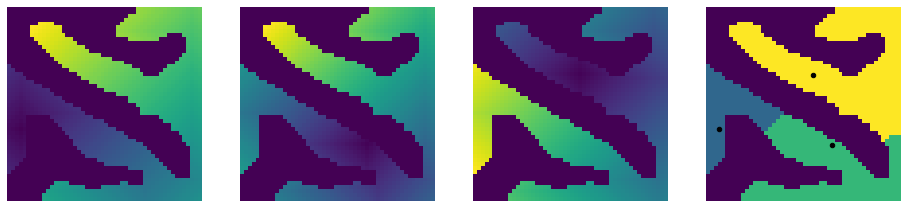

In [15]:
# Create helper structures
# obstacle_map = (area_map == OBS).copy() # False = Obstacle
obstacle_coords = get_obstacle_coords(area_map) 

E = get_evaluation_matrices(start_points, area_map) # Distance maps for each
A = get_assignment_matrix(E) # Assignment matrix.

[imshow(e, 1,4,i+1, (16,4))for i,e in enumerate(E)]
imshow(A, 1,4,4)
imshow_scatter([start_points], color="black")

In [16]:
"""
Values used in the algo.
"""

# % of cells to be assigned on coverage speed basis.
coverage_ratio = get_coverage_ratio(drone_speed, drone_coverage) 
nobs_count = get_no_obs_count(area_map)                # Number of coverable cells.
assigned_count_dict = get_assigned_count(A, arr=False) # Counts in the form of a dict
assigned_count = get_assigned_count(A)                 # Counts in the form of an array
optimal_count = np.round(coverage_ratio * nobs_count)  # Optimal number of cells assigned to each drone
diff = optimal_count - assigned_count                  # Required change in count of cells assigned
c = get_c(area_map)

"""
fair_share = -diff # UR :: $m_i = m_i + c(k_i - f)$; fair_share :: (k_i - f)
"""

coverage_ratio, nobs_count, assigned_count_dict, assigned_count, optimal_count, diff, c

(array([0.33333333, 0.33333333, 0.33333333]),
 1318,
 {0: 221, 1: 433, 2: 664},
 array([221, 433, 664]),
 array([439., 439., 439.]),
 array([ 218.,    6., -225.]),
 0.0001)

In [17]:
print("current count : ",assigned_count)
print("target count  : ",optimal_count)
print("RMSE : ",rmse(assigned_count, optimal_count))

current count :  [221 433 664]
target count  :  [439. 439. 439.]
RMSE :  180.90973808320362


In [20]:
E_ = E.copy()
%time A_ = iterate(200, start_points, E_, c, nobs_count, coverage_ratio, print_stuff=True)
assigned_count_= get_assigned_count(A_)
print("current_count : ", assigned_count_)
print("RMSE : ",rmse(assigned_count_, optimal_count))

ASGN : [221 438 659]
RMSE : 178.82
ASGN : [221 438 659]
RMSE : 178.82
ASGN : [221 443 654]
RMSE : 176.79
ASGN : [221 443 654]
RMSE : 176.79
ASGN : [221 448 649]
RMSE : 174.84
ASGN : [226 443 649]
RMSE : 172.71
ASGN : [226 443 649]
RMSE : 172.71
ASGN : [226 443 649]
RMSE : 172.71
ASGN : [226 449 643]
RMSE : 170.38
ASGN : [231 444 643]
RMSE : 168.23
ASGN : [231 444 643]
RMSE : 168.23
ASGN : [231 444 643]
RMSE : 168.23
ASGN : [231 450 637]
RMSE : 165.92
ASGN : [237 444 637]
RMSE : 163.33
ASGN : [237 444 637]
RMSE : 163.33
ASGN : [242 439 637]
RMSE : 161.26
ASGN : [242 439 637]
RMSE : 161.26
ASGN : [242 439 637]
RMSE : 161.26
ASGN : [242 446 630]
RMSE : 158.47
ASGN : [248 490 580]
RMSE : 140.19
ASGN : [653 264 401]
RMSE : 161.11
ASGN : [724 193 401]
RMSE : 218.47
ASGN : [725 192 401]
RMSE : 219.28
ASGN : [725 192 401]
RMSE : 219.28
ASGN : [725 192 401]
RMSE : 219.28
ASGN : [726 191 401]
RMSE : 220.09
ASGN : [726 191 401]
RMSE : 220.09
ASGN : [726 191 401]
RMSE : 220.09
ASGN : [727 190 401]

/Users/alan/opt/anaconda3/envs/data_sci/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: assigned areas may have gone below number of drones, run for fewer epochs


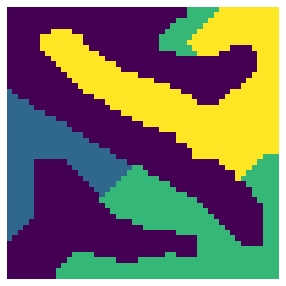

In [19]:
imshow(A_)

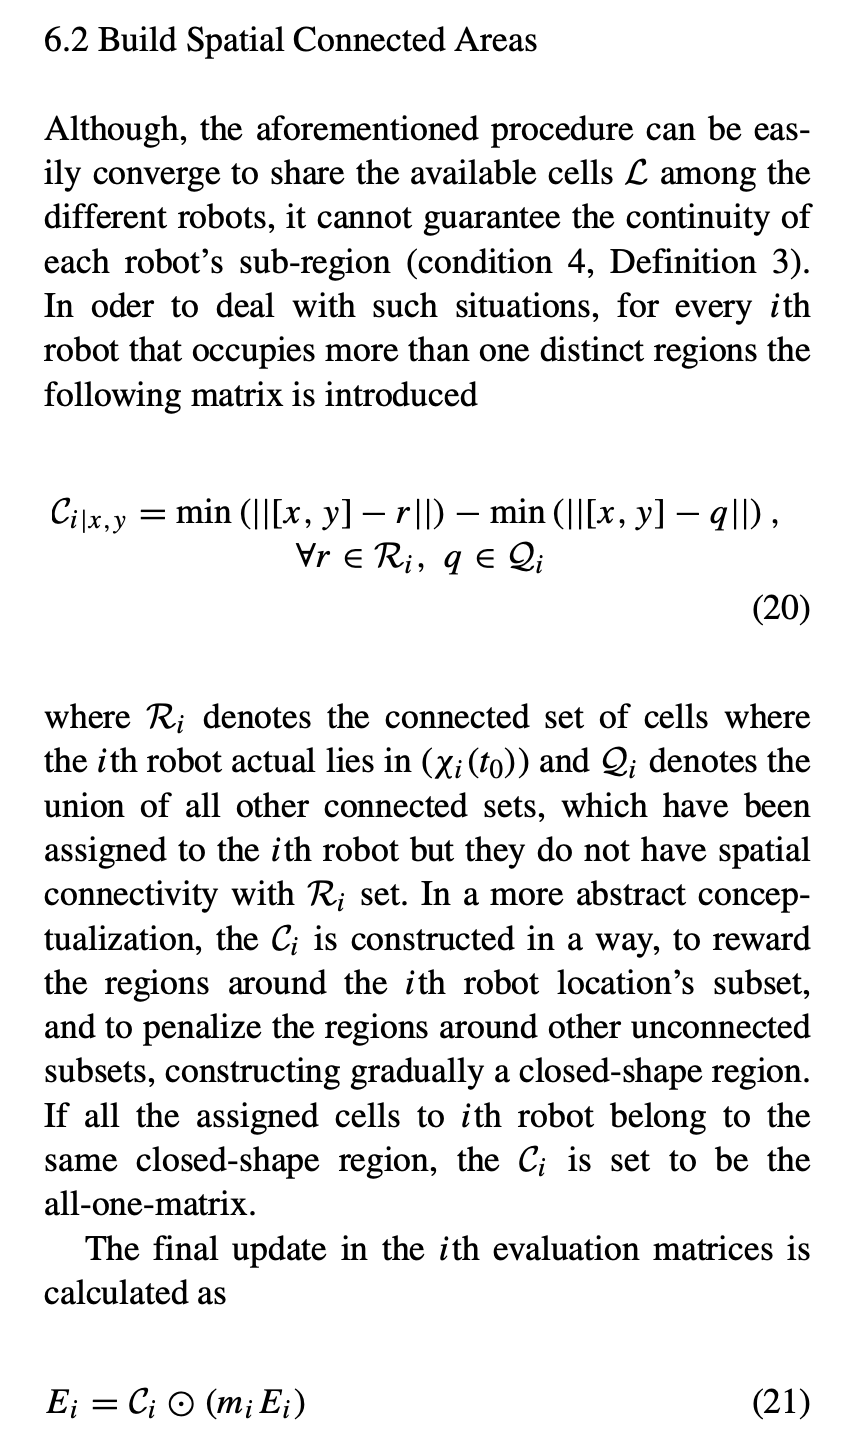